## Jupyter e SQLite

SQLite é uma engine de banco de dados transacional autocontida que dispensa servidor e configuração. Utilizando a mesma, é possível importar um dump de banco de dados a partir de um arquivo .sql e realizar consultas e outras operações.

* SQLite: https://www.sqlite.org/index.html
* Documentação: https://docs.python.org/2/library/sqlite3.html
* Tutorial: https://www.tutorialspoint.com/sqlite/sqlite_python.htm

Para os exemplos, utilizaremos o banco de dados utilizado no TP 1 da turma de Introdução a Banco de Dados 2019/1. O banco é representado pelo schema abaixo:

![Modelo_BD.png](https://github.com/filipefbn/jupyter_intro_class_ibd/blob/master/data/schema.PNG?raw=true)


In [0]:
import io
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Download do dump:
!wget --quiet -P /tmp/ibd/ https://raw.githubusercontent.com/filipefbn/jupyter_intro_class_ibd/master/data/despesas_publicas_tp1.sql

### Criação da conexão com o banco

* No momento da conexão, é informado o nome do arquivo onde será montado o banco de dados. No nosso caso, este arquivo não precisa ser pré-existente, porque iremos carregar as informações de um dump
* Se este comando for executado com um arquivo que já existe e possui as mesmas tabelas que serão criadas, ocorrerá um erro no momento da execução do script mais à frente

In [0]:
conn = sqlite3.connect('/tmp/ibd/conn_despesas_publicas_tp1.db')
cursor = conn.cursor()

### Execução do script para carga do dump

* Criada a conexão, iremos utilizar o arquivo .sql disponibilizado para recuperar o schema e os dados do banco

In [0]:
f = io.open('/tmp/ibd/despesas_publicas_tp1.sql', 'r', encoding='ISO-8859-1')
sql = f.read()
cursor.executescript(sql)

### Realizando consultas no banco de dados

* Criada a conexão e realizada a carga dos dados no banco, pode ser executada qualquer consulta SQL
* O SQLite3 permite que o retorno dos dados seja feito em vários formatos, entretanto, utilizaremos o retorno em um dataframe do Pandas

**CONSULTA 1:** todos os órgãos ordenados pela quantidade de orgãos subordinados de forma decrescente

In [0]:
df = pd.read_sql_query("SELECT * FROM ORGAO ORDER BY QTD_ORGAOS_SUBORDINADOS DESC", conn)
df

,COD_ORGAO,NOME_ORGAO,QTD_ORGAOS_SUBORDINADOS
0,26000,Ministério da Educação,104
1,30000,Ministério da Justiça e Segurança Pública,6
2,22000,"Ministério da Agricultura, Pecuária e Abastec",5
3,24000,"Ministério da Ciência, Tecnologia, Inovações",4
4,52000,Ministério da Defesa,4
5,53000,Ministério da Integração Nacional,4
6,25000,Ministério da Fazenda,3
7,36000,Ministério da Saúde,3
8,20000,Presidência da República,2
9,39000,"Ministério dos Transportes, Portos e Aviação",2


**CONSULTA 2:** todos os nomes dos programas de governo e a soma de suas despesas totais no ano de 2018 ordenadas de forma decrescete, desde que as despesas tenham sido superiores a 0

In [0]:
df = pd.read_sql_query("SELECT P.NOME_PROGRAMA_GOVERNO, SUM(D.VALOR_DESPESA) AS VALOR_DESPESA " + 
                       "FROM DESPESA_PUBLICA AS D " +
                       "INNER JOIN PROGRAMA_GOVERNO AS P " +
                       "ON D.COD_PROGRAMA_GOVERNO = P.COD_PROGRAMA_GOVERNO " + 
                       "GROUP BY P.NOME_PROGRAMA_GOVERNO " +
                       "HAVING SUM(VALOR_DESPESA) > 0 " +
                       "ORDER BY VALOR_DESPESA DESC", conn)
df

,NOME_PROGRAMA_GOVERNO,VALOR_DESPESA
0,BRASIL SEM MISERIA,387175.60
1,ENEM,334262.06
2,PRONATEC,60262.46
3,CONTROLE DO CANCER,38971.19
4,MAIS MEDICOS,14400.00
5,REGULARIZACAO FUNDIARIA,1497.26
6,REDE CEGONHA,1210.00


**CONSULTA 3:** todos os gastos totais por mês em despesas públicas com função de 'Educação', ordenadas pelos meses do ano

In [0]:
df = pd.read_sql_query("SELECT D.MES_DESPESA, SUM(D.VALOR_DESPESA) AS VALOR_DESPESA " + 
                       "FROM DESPESA_PUBLICA AS D " +
                       "INNER JOIN DETALHAMENTO_FUNCAO AS DF " +
                       "ON D.COD_DETALHAMENTO = DF.COD_DETALHAMENTO " +
                       "INNER JOIN FUNCAO AS F " +
                       "ON DF.COD_FUNCAO = F.COD_FUNCAO " +
                       "WHERE F.NOME_FUNCAO = 'Educação' " +
                       "GROUP BY D.MES_DESPESA " +
                       "ORDER BY D.MES_DESPESA", conn)
df

,MES_DESPESA,VALOR_DESPESA
0,1,7000.00
1,2,0.00
2,3,0.00
3,4,18178.00
4,5,28073.08
5,6,135.36
6,7,0.00
7,8,3126.00
8,9,334126.70
9,10,385.38


**VISUALIZAÇÃO DA CONSULTA 3:** gráfico de barras com o valor da despesa mensal para educação

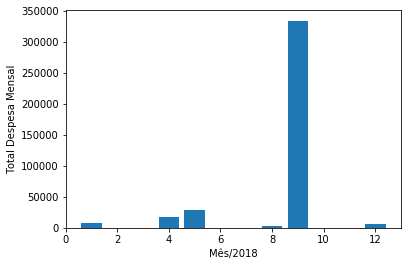

In [0]:
plt.bar(df['MES_DESPESA'].tolist(), df['VALOR_DESPESA'].tolist())

plt.xlabel("Mês/2018")
plt.ylabel("Total Despesa Mensal")
plt.show()

### Fechamento da conexão com o banco

* Após serem realizadas todas as consultas necessárias, é aconselhavel encerrar formalmente a conexão com o banco de dados

In [0]:
conn.close()